<div align="center">

# 🧠 **Deep Learning Project**

# 😃 **Facial Emotion Recognition System**

---

## 👨‍🎓 **Submitted By**
**Abdul Rafiu**  
Section **E**  
CMS-ID: **023-22-0252**

---

## 👨‍🏫 **Submitted To**
**Dr. Asif Khan**

---

## 📘 **Google Colab Notebook**

</div>


# **CELL 1 — Mount Drive + Extract Dataset + Set Paths**

Connects Google Colab with Google Drive so that Colab can access files.
Then it takes dataset.zip file from Drive, extracts it inside Colab, and creates the correct folder paths for the training and testing images.

If the dataset was extracted earlier, it won’t extract again  this prevents duplication.

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

# Path of your zip file in Google Drive
zip_path = "/content/drive/MyDrive/DL_Project/dataset.zip"

# Extract ZIP into /content
extract_path = "/content/dataset"

# Extract only if not extracted already
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content")
    print("Dataset extracted successfully!")
else:
    print("Dataset already extracted.")

# Update dataset paths
train_path = "/content/dataset/train"
test_path = "/content/dataset/test"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset already extracted.


# **CELL 2 — Import all required libraries**

loads all external libraries like OpenCV, NumPy, Keras, Matplotlib, etc. which we need for data loading, training, and visualization.

---



In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import regularizers


# **CELL 3 — Define emotion categories and helper functions**

Here i map emotion names to numeric labels and create functions to read images from folders.

---



In [ ]:
emotion_labels = {"angry": 0, "happy": 1, "neutral": 2, "sad": 3, "surprise": 4}

def resolve_label(folder_name):
    return emotion_labels.get(folder_name, None)

def load_image_data(directory_path):
    img_storage = []
    lbl_storage = []

    for emotion_dir in os.listdir(directory_path):
        lbl_value = resolve_label(emotion_dir)

        if lbl_value is not None:
            for img_name in os.listdir(os.path.join(directory_path, emotion_dir)):
                img_gray = cv2.imread(os.path.join(directory_path, emotion_dir, img_name), cv2.IMREAD_GRAYSCALE)

                if img_gray is not None:
                    img_resized = cv2.resize(img_gray, (48, 48))
                    img_colored = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)

                    img_storage.append(img_colored)
                    lbl_storage.append(lbl_value)

    return img_storage, lbl_storage


# **CELL 4 — Load dataset from extracted train/test folders**

Reads images from the training and testing directories.

In [ ]:
train_imgs, train_lbls = load_image_data(train_path)
test_imgs, test_lbls = load_image_data(test_path)


# **CELL 5 — Normalize images and convert to NumPy arrays**

This prepares the data for the neural network.

In [ ]:
train_imgs = np.array(train_imgs) / 255.0
train_lbls = np.array(train_lbls)

test_imgs = np.array(test_imgs) / 255.0
test_lbls = np.array(test_lbls)


# **CELL 6 — Split into train/validation sets**

We separate 20% of training data for validation.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_imgs, train_lbls, test_size=0.2, random_state=42
)


# **CELL 7 — Data augmentation (rotation, zoom, shift, etc.)**

This artificially increases dataset variety to reduce overfitting.

In [ ]:
aug_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = aug_generator.flow(X_train, y_train, batch_size=32)

valid_gen = ImageDataGenerator().flow(X_valid, y_valid, batch_size=32, shuffle=False)


# **CELL 8 — Load MobileNetV2 and freeze some layers**

We use MobileNetV2 as the feature extractor.

In [ ]:
feature_base = MobileNetV2(input_shape=(48, 48, 3), include_top=False, weights='imagenet')

for lyr in feature_base.layers[:100]:
    lyr.trainable = False


/tmp/ipython-input-392088015.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  feature_base = MobileNetV2(input_shape=(48, 48, 3), include_top=False, weights='imagenet')


# **CELL 9 — Build the full neural network**

Adds custom layers on top of MobileNetV2 to classify 5 emotions.

In [ ]:
emotion_model = models.Sequential([
    feature_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])


# **CELL 10 — Compile the model**

Defines optimizer, loss function, and evaluation metrics.

In [ ]:
opt_engine = optimizers.Adam(learning_rate=0.0001)

emotion_model.compile(
    optimizer=opt_engine,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# **CELL 11 — Callbacks setup (Early Stop, LR Reduce, Model Save)**

These help improve training stability.

In [ ]:
callback_pack = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    callbacks.ModelCheckpoint('best_model.weights.h5',  # ✅ notice .weights.h5
                              save_weights_only=True,
                              save_best_only=True)
]


# **CELL 12 — Train the model**

Training begins here.

In [ ]:
training_logs = emotion_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100,
    callbacks=callback_pack
)


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


605/605 ━━━━━━━━━━━━━━━━━━━━ 64s 69ms/step - accuracy: 0.2375 - loss: 20.0781 - val_accuracy: 0.3486 - val_loss: 17.2929 - learning_rate: 1.0000e-04
Epoch 2/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.2873 - loss: 17.0685 - val_accuracy: 0.3720 - val_loss: 15.1693 - learning_rate: 1.0000e-04
Epoch 3/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.3153 - loss: 14.3796 - val_accuracy: 0.3962 - val_loss: 12.3760 - learning_rate: 1.0000e-04
Epoch 4/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.3472 - loss: 11.8153 - val_accuracy: 0.4072 - val_loss: 10.0227 - learning_rate: 1.0000e-04
Epoch 5/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.3652 - loss: 9.5236 - val_accuracy: 0.4239 - val_loss: 7.8316 - learning_rate: 1.0000e-04
Epoch 6/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.3982 - loss: 7.4692 - val_accuracy: 0.4222 - val_loss: 6.2277 - learning_rate: 1.0000e-04
Epoch 7/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/

# **CELL 13 — Evaluate model on test set**

We check final performance.

In [ ]:
test_loss, test_acc = emotion_model.evaluate(test_imgs, test_lbls)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5258 - loss: 1.2049
Test Accuracy: 0.6078106760978699
Test Loss: 1.0390294790267944


# **CELL 14 — Generate predictions on test data**

Used for classification report and confusion matrix.

In [ ]:
test_predictions = np.argmax(emotion_model.predict(test_imgs), axis=1)

unique_classes = sorted(np.unique(np.concatenate([test_lbls, test_predictions])))
emotion_names = [name for name, idx in emotion_labels.items() if idx in unique_classes]


189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step


# **CELL 15 — Print classification report**

Shows precision, recall, and F1-score.

---



In [ ]:
print("Classification Report:")
print(classification_report(test_lbls, test_predictions, labels=unique_classes, target_names=emotion_names))


Classification Report:
              precision    recall  f1-score   support

       angry       0.52      0.46      0.49       958
       happy       0.71      0.76      0.73      1774
     neutral       0.49      0.62      0.54      1233
         sad       0.55      0.41      0.47      1247
    surprise       0.77      0.74      0.75       831

    accuracy                           0.61      6043
   macro avg       0.61      0.60      0.60      6043
weighted avg       0.61      0.61      0.60      6043



# **CELL 16 — Display confusion matrix**

Shows misclassifications between emotion classes.

---



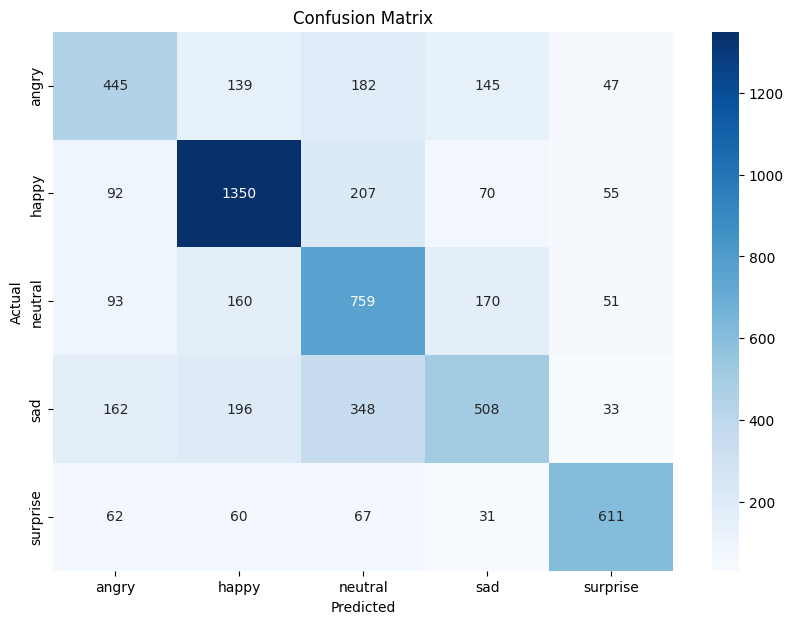

In [ ]:
matrix = confusion_matrix(test_lbls, test_predictions, labels=unique_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_names, yticklabels=emotion_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# **CELL 17 — Plot training curves (Accuracy & Loss)**

Helps visualize how well the model trained.

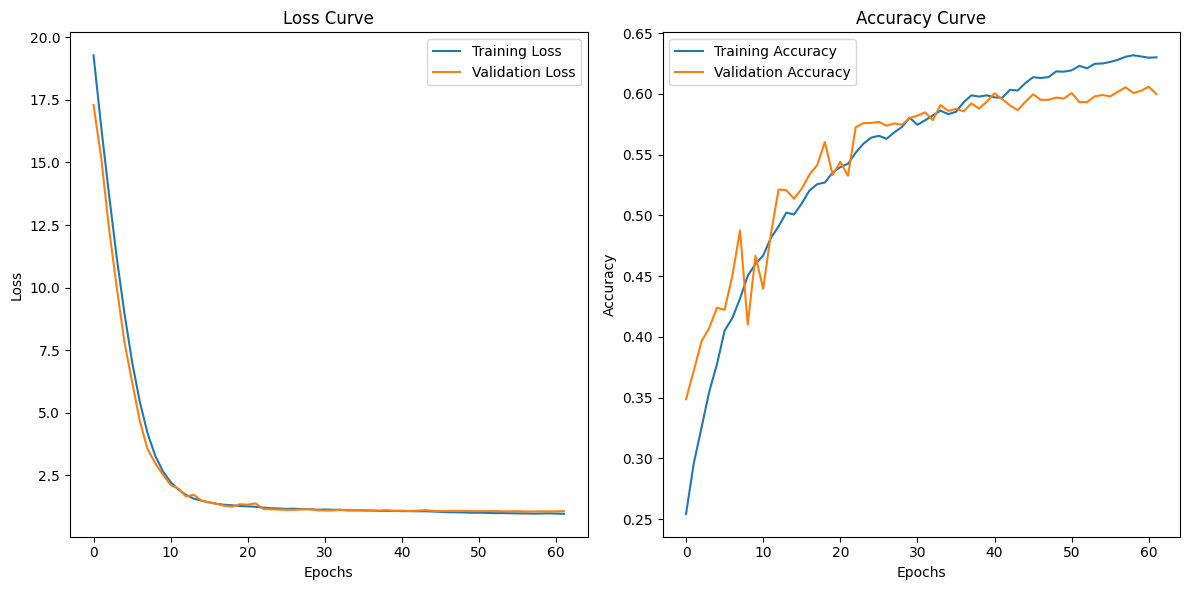

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(training_logs.history['loss'], label='Training Loss')
plt.plot(training_logs.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_logs.history['accuracy'], label='Training Accuracy')
plt.plot(training_logs.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# **CELL 18 — Save Trained Model to Colab, Drive & Download**

This cell saves your trained model in three ways:


*   Saves best_model.keras inside Colab’s storage.
*   Saves another copy directly into your Google Drive so you can keep it permanently.
*   Downloads the model to laptop so can use it in GUI or desktop application.


This ensures you always have a backup of your trained model in all locations.

---



In [ ]:
emotion_model.save_weights("best_model.weights.h5")


emotion_model.save("/content/drive/MyDrive/DL_Project/best_model_weights.h5")


